# Summary

The following code identifies the most important features of the initial selection using three different methods: built-in feature importance, Pearson's correlation, and permutation feature importance.

*Note: LightGBM handles only one output at a time, so feature importances are displayed separately for each output column.* 

#### Setup

In [6]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np

pth = '../data/train_test_split'
train_data = pd.read_csv(f'{pth}/train.csv')
val_data = pd.read_csv(f'{pth}/validate.csv')
test_data = pd.read_csv(f'{pth}/test.csv')

cols = train_data.columns

X_train = train_data[cols[:-4]]
y_train = train_data[cols[-4:]].copy()
y_train[cols[-1]] = y_train[cols[-1]].round().astype(int)


X_val = val_data[cols[:-4]]
y_val = val_data[cols[-4:]].copy()
y_val[cols[-1]] = y_val[cols[-1]].round().astype(int)

num_features = X_train.shape[1]

#### Built-In Feature Importance

Column: FATAL_COUNT
Features Used: 20/21
Column: INJURY_COUNT
Features Used: 21/21
Column: TOT_INJ_COUNT
Features Used: 21/21
Column: MAX_SEVERITY_LEVEL
Features Used: 21/21


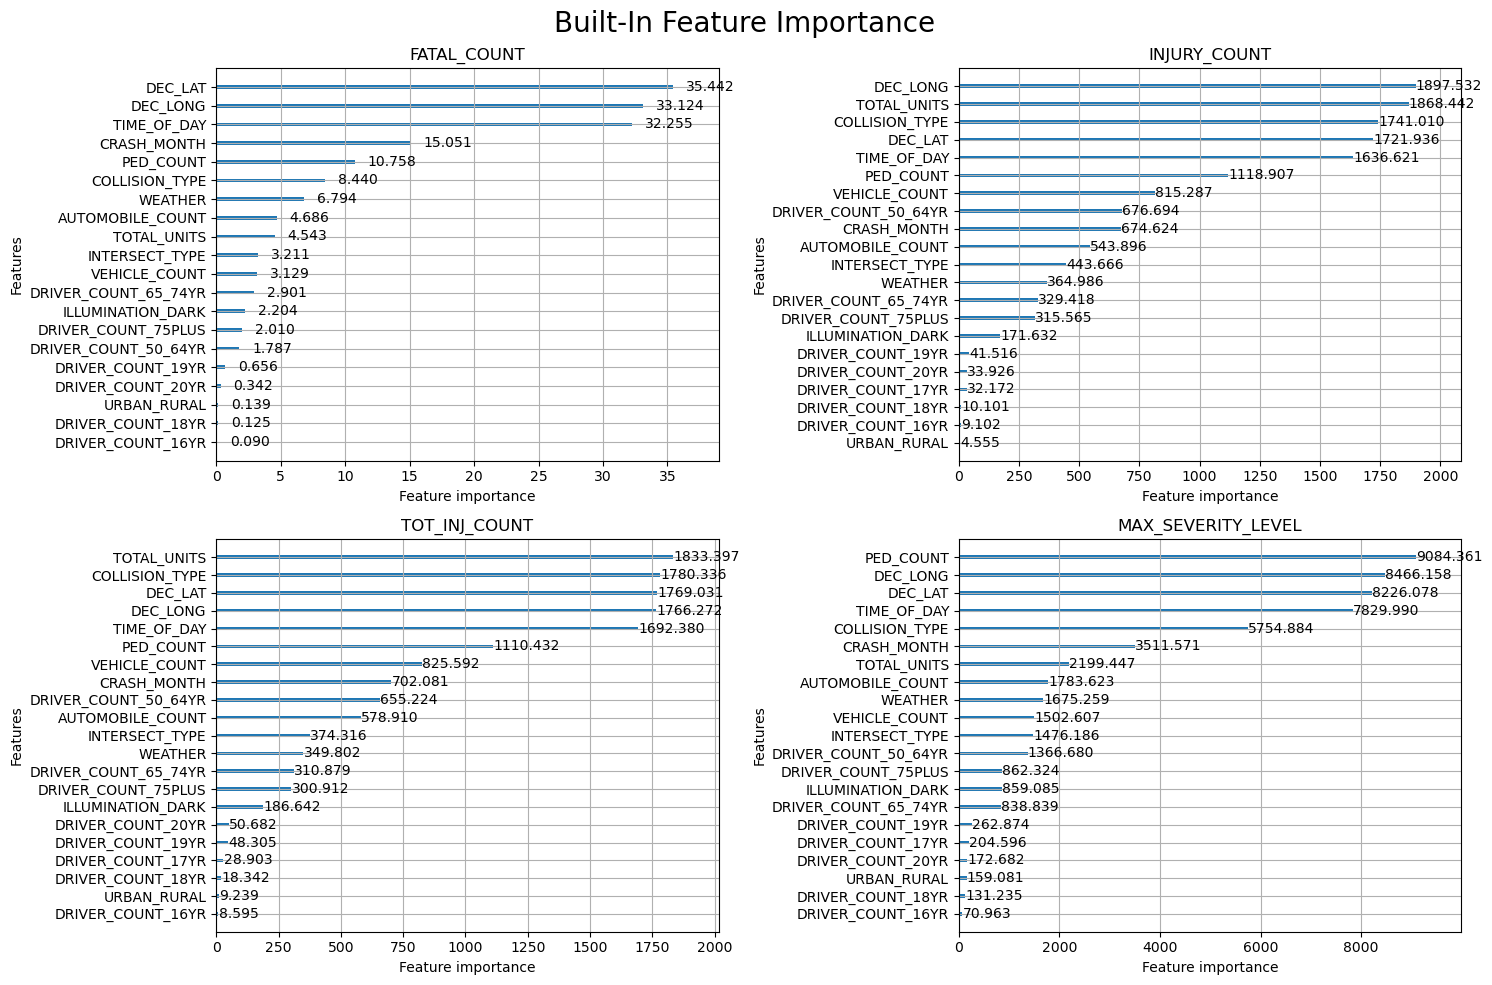

In [7]:
reg_params = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting': 'gbdt',
    'verbose': -1,
    'learning_rate': 0.05, 
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8, 
    'n_iter': 100, 
    'min_data_in_leaf': 20,
    'max_depth': 5,
    'num_leaves': 35,
    'bagging_freq': 5,
    'random_state': 69,
    'force_row_wise': True,
}

multi_params = {
    'objective': 'multiclass', 
    'metric': 'multi_logloss', 
    'boosting': 'gbdt',
    'verbose': -1,
    'num_class': 5,
    'learning_rate': 0.05, 
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8, 
    'n_iter': 100, 
    'min_data_in_leaf': 20,
    'max_depth': 5,
    'num_leaves': 35,
    'bagging_freq': 5,
    'random_state': 69,
    'force_row_wise': True,
}

models = {}
out_cols = cols[-4:]
reg_cols, multi_col = y_train.columns[:3], y_train.columns[3]

for reg_col in reg_cols:
    reg_train_set = lgb.Dataset(X_train, label=y_train[reg_col])
    reg_model = lgb.train(reg_params, reg_train_set)
    models[reg_col] = reg_model
    reg_tot_features = np.count_nonzero(reg_model.feature_importance())
    print(f"Column: {reg_col}\nFeatures Used: {reg_tot_features}/{num_features}")

multi_train_set = lgb.Dataset(X_train, label=y_train[multi_col])
multi_model = lgb.train(multi_params, multi_train_set)
models[multi_col] = multi_model
multi_tot_features = np.count_nonzero(multi_model.feature_importance())
print(f"Column: {multi_col}\nFeatures Used: {multi_tot_features}/{num_features}")

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for ax, (col, model) in zip(axs.ravel(), models.items()):
    lgb.plot_importance(model, importance_type='gain', max_num_features=num_features, ax=ax, title=f'{col}')

plt.suptitle('Built-In Feature Importance', fontsize=20)
plt.tight_layout()
plt.show()

#### Pearson's Correlation

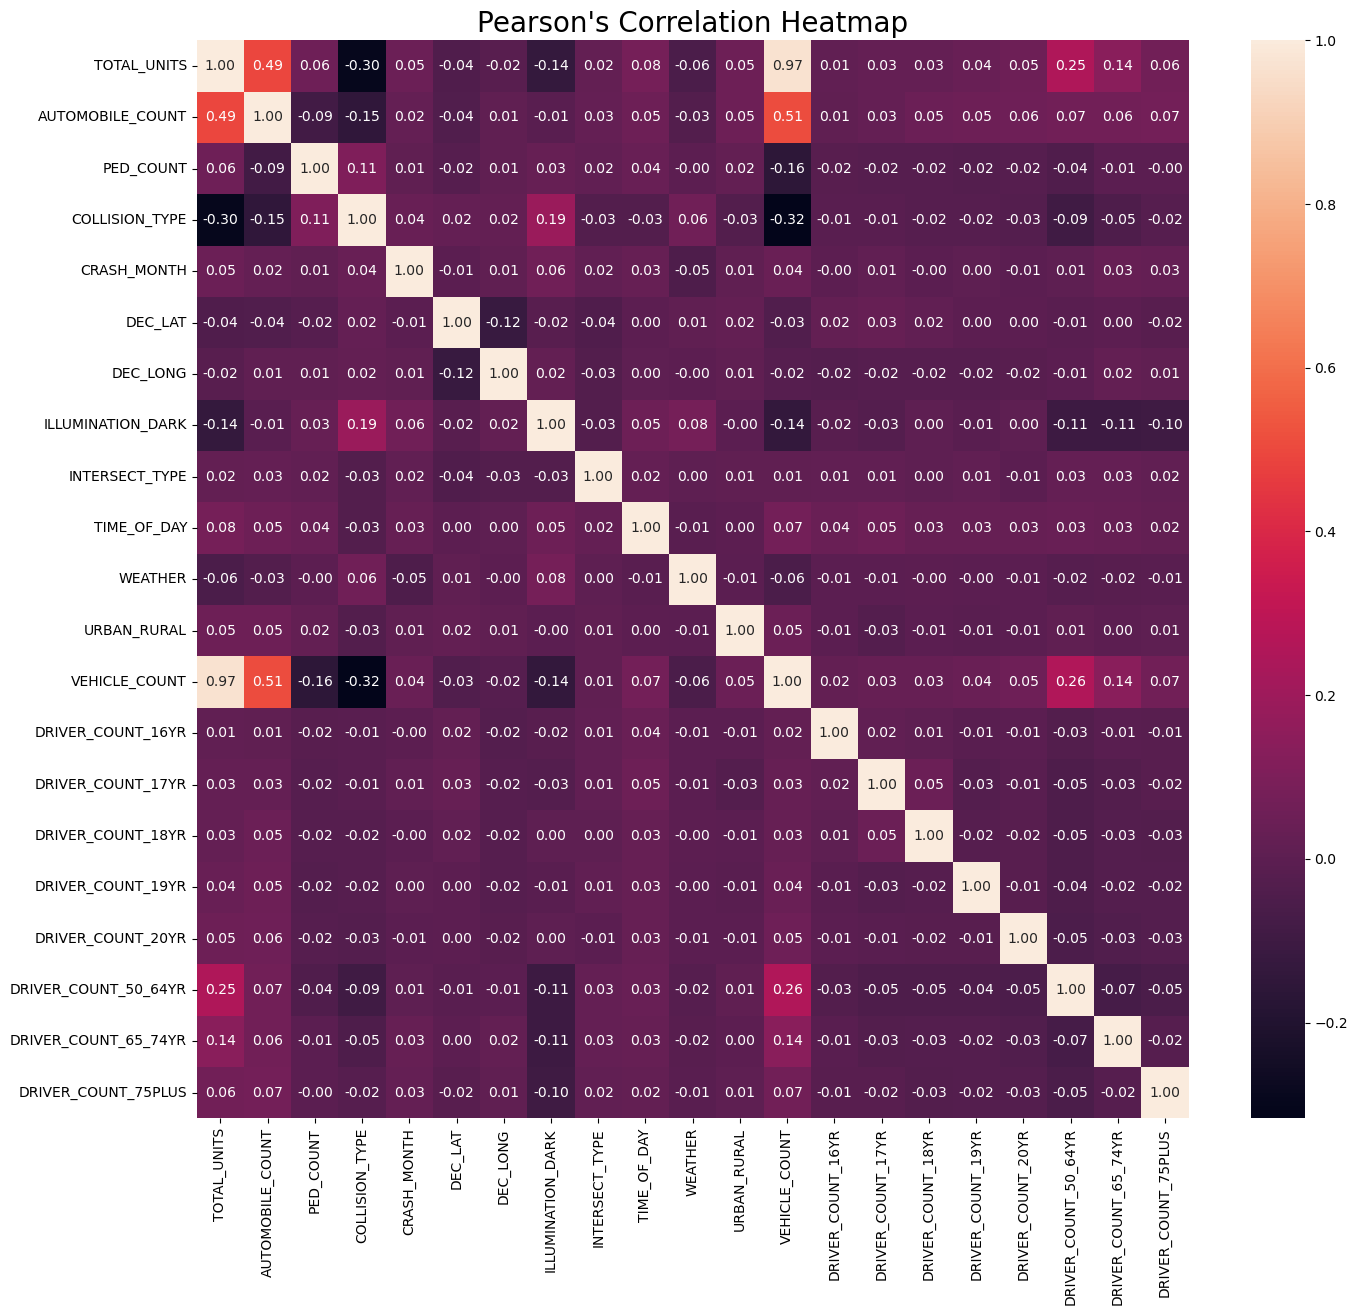

In [8]:
import seaborn as sb

pearsons = X_train.corr()
plt.figure(figsize=(16, 14))
sb.heatmap(pearsons, annot=True, fmt='.2f')
plt.title("Pearson's Correlation Heatmap", fontsize=20)
plt.show()

#### Permutation Feature Importance

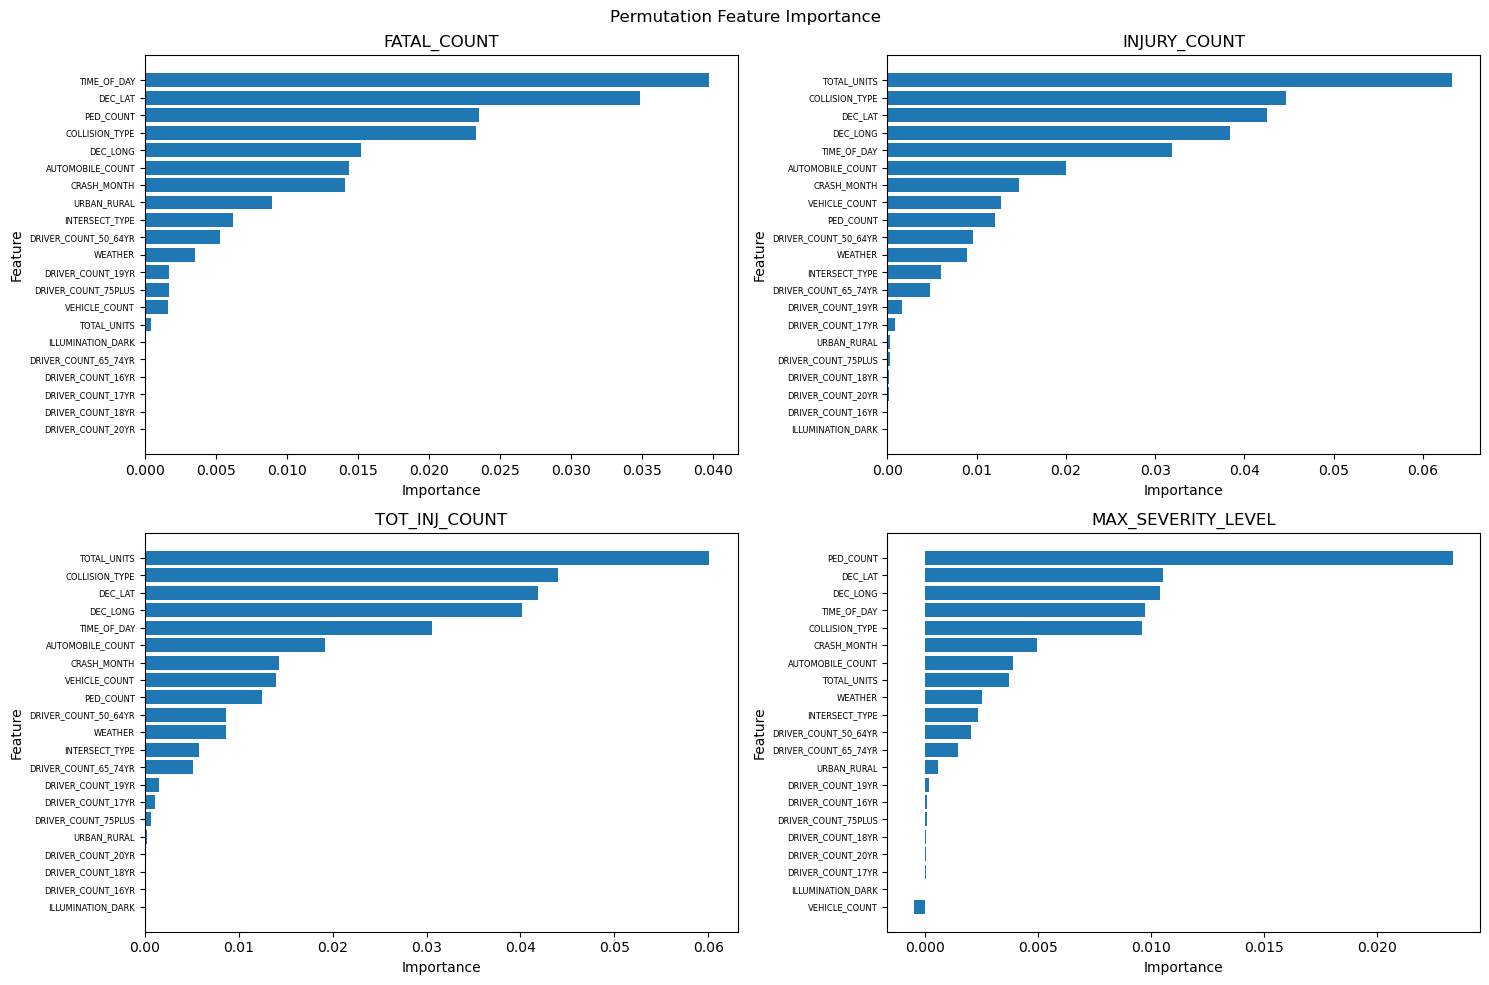

In [9]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.inspection import permutation_importance


def plot_data(features, importance, ax=None, title=None):
    sorted_idx = importance.argsort()
    sorted_features = features[sorted_idx]
    sorted_importance = importance[sorted_idx]

    if ax is not None:
        ax.barh(sorted_features, sorted_importance)
        ax.set_title(title)
        ax.set_xlabel('Importance')
        ax.set_ylabel('Feature')
        ax.tick_params(axis='y', labelsize=6)


wrapped_models = {}
features = X_val.columns

fig2, axs2 = plt.subplots(2, 2, figsize=(15, 10))

for ax2, reg_col in zip(axs2.ravel()[:3], reg_cols):
    reg_model2 = LGBMRegressor(**reg_params)
    reg_model2.fit(X_val, y_val[reg_col])
    wrapped_models[reg_col] = reg_model2

    reg_pfi = permutation_importance(reg_model2, X_val, y_val[reg_col])
    reg_pfi_importances = reg_pfi['importances_mean']
    plot_data(features, reg_pfi_importances, ax=ax2, title=reg_col)

    
multi_model2 = LGBMClassifier(**multi_params)
multi_model2.fit(X_val, y_val[multi_col])
wrapped_models[multi_col] = multi_model2

multi_pfi = permutation_importance(multi_model2, X_val, y_val[multi_col])
multi_pfi_importances = multi_pfi['importances_mean']
plot_data(features, multi_pfi_importances, ax=axs2.ravel()[3], title=multi_col)

plt.suptitle('Permutation Feature Importance')
plt.tight_layout()
plt.show()

#### Export new .csv with selected features

In [10]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from data_cleaning.save_data import save_df


# Final selected features and outputs
selected_features = [
    'VEHICLE_COUNT', 'PED_COUNT' ,'COLLISION_TYPE', 'CRASH_MONTH', 
    'DEC_LAT', 'DEC_LONG', 'TIME_OF_DAY', 'WEATHER',
    'FATAL_COUNT', 'INJURY_COUNT', 'TOT_INJ_COUNT', 'MAX_SEVERITY_LEVEL'
]

data = {
    'train': train_data,
    'validate': val_data,
    'test': test_data
}

# Uncomment this to save final training, validation, and testing datasets
'''
dest = '../data/train_test_split_final'
for name, dataset in data.items():
    save_df(dataset[selected_features], name, dest)
'''

"\ndest = '../data/train_test_split_final'\nfor name, dataset in data.items():\n    save_df(dataset[selected_features], name, dest)\n"